# 2 Урок: Метрики в задаче ранжирования

**Задача ранжирования** (`LTR` - `Learning To Rank`) - класс задач машинного обучения `с учителем` (_supervised_) или `с частичным обучением` (_semi-supervised_), заключающихся в нахождении модели, целью которой является наилучшее приближение и обобщение способа ранжирования в обучающей выборке на новые данные.

`Обучение с учителем`: указано, насколько какой-то документ подходит к конкретному запросу (насколько они релевантные).

`Частичное привлечение учителя`: использование, как правило, большого корпуса неразмеченных данных с целью улучшения качества предсказания.

Пример техник для semi-supervised обучения — `псведолейблинг (_pseudo-labeling_)`: модель обучается на маленьком наборе данных с разметкой, а затем делает предсказания на всём огромном объёме данных. Предсказанные лейблы становятся новыми таргетами для обучения (новой целевой переменной). Таким образом можно получить улучшение качества в semi-supervised режиме.

$Q$ – набор запросов $\{q_1, q_2, ..., q_m\}$

$D$ – набор документов

$D_i = \{d_{i, 1}, d_{i, 2}, ..., d_{o, n_i}\}$ – набор документов, релевантных $i$-му запросу $q$

$d_{i, j}$ – элемент с индексом $j$ в $D_i$

$\bm y_i = \{y_{i, 1}, y_{i, 2}, ..., y_{i, n_i}\}$ – набор оценок релевантности для $i$-го запроса (размер тот же, что и у $D_i$)

$S = \{(q_i, D_i), \bm y_i\}^m_{i=1}$ – тренировочный набор данных

$x_{i, j} = \phi (q_i, d_{i, j})$ – вектор признаков для $i$-го запроса и $j$-го документа $(i = \overline{1, m}, j = \overline{1, n_i}$)

$\phi$ – функция для получения признаков (BM25, PageRank, мультимодальные модели)

$\bm x_i = \{x_{i, 1}, x_{i, 2}, ..., x_{i, n_i}\}$ – признаки набора документов, релевантных $i$-му запросу $q$

$f(q, d) = f(x)$ – ранжирующая модель, оценивающая релевантность для пары $q, d$ на основе признаков $x$

$F(q, D) = F(\bm x)$ – глобальная ранжирующая модель

**Задача** — создание такой глобальной модели, которая будет работать над всем корпусом документов.

## Оценка качества ранжирования метриками классификации

In [1]:
from math import log2
import torch

from pprint import pprint

from typing import List, Dict, Any, Optional, Union

* Точность:
$$ 
    precision = \frac{|\{relevant\ documents\} \cap \{retrieved\ documents \}|}{|\{retrieved\ documents \}|}
$$
* Полнота:
$$ 
    recall = \frac{|\{relevant\ documents\} \cap \{retrieved\ documents \}|}{|\{relevant\ documents \}|}
$$
* Ограничения на расчёт в Top-k (@k):  
    $precision@5 -$ значение точности по первым топ-5 результатам выдачи.

* $F1, F_\beta$-меры:
$$
    F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\beta^2 \cdot precision + recall}
$$
* PR-auc (Площадь по PR кривой):
    * Сортируем предсказания по убыванию релевантности;
    * Считаем значение точности и полноты по первой паре;
    * Понижаем значение порога, чтобы выше порога было две пары;
    * Повторяем до тех пор, пока не добавим все элементы.
    * Опционально: применить отсечение ($Recall@Precision=N$)

In [2]:
def num_swapped_pairs(ys_true: torch.Tensor, ys_pred: torch.Tensor) -> int:
    """Функция для подсчёта неправильно упорядоченных пар,
        правильно <=> от наибольшего к наименьшему в ys_true.
        Что эквивалентно числу перестановок пар.

    Parameters
    ----------
    ys_true : `torch.Tensor`
        Correct labels rank.
    ys_pred : `torch.Tensor`
        Predicted labels rank.

    Returns
    -------
    swapped_cnt : `int`
        #_of_swapped_pairs.
    """
    ys_pred_sorted, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    
    num_objects = ys_true_sorted.shape[0]
    swapped_cnt = 0
    for cur_obj in range(num_objects - 1):
        for next_obj in range(cur_obj + 1, num_objects):
            if ys_true_sorted[cur_obj] < ys_true_sorted[next_obj]:
                if ys_pred_sorted[cur_obj] > ys_pred_sorted[next_obj]:
                    swapped_cnt += 1
            elif ys_true_sorted[cur_obj] > ys_true_sorted[next_obj]:
                if ys_pred_sorted[cur_obj] < ys_pred_sorted[next_obj]:
                    swapped_cnt += 1
    return swapped_cnt

In [3]:
def precission_at_k(ys_true: torch.Tensor, ys_pred: torch.Tensor, k: int) -> float:
    """Metric:
        Calculates the precission at top-k predictions.

    Parameters
    ----------
    ys_true : `torch.Tensor`
        Correct labels rank.
    ys_pred : `torch.Tensor`
        Predicted labels rank.

    Returns
    -------
    p_at_k : `float`
    """
    if ys_true.sum() == 0:
        return -1
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    hits = ys_true_sorted[:k].sum()
    p_at_k = hits / min(ys_true.sum(), k)
    return float(p_at_k)

In [4]:
def reciprocal_rank(ys_true: torch.Tensor, ys_pred: torch.Tensor) -> float:
    """Metric:
        Calculates the reciprocal rank.

    Parameters
    ----------
    ys_true : `torch.Tensor`
        Correct labels rank.
    ys_pred : `torch.Tensor`
        Predicted labels rank.

    Returns
    -------
    reciprocal_rank : `float`
    """
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    
    for idx, cur_y in enumerate(ys_true_sorted, 1):
        if cur_y == 1:
            return 1 / idx
    return 0

In [5]:
def average_precision(ys_true: torch.Tensor, ys_pred: torch.Tensor) -> float:
    """Metric:
        Calculates the Average Precision (AP) = \sum_K {#_relevant_documents} / k.

    Parameters
    ----------
    ys_true : `torch.Tensor`
        Correct labels rank.
    ys_pred : `torch.Tensor`
        Predicted labels rank.

    Returns
    -------
    avg_precision : `float`
    """
    if ys_true.sum() == 0:
        return -1
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    rolling_sum = 0
    num_correct_ans = 0
    
    for idx, cur_y in enumerate(ys_true_sorted, start=1):
        if cur_y == 1:
            num_correct_ans += 1
            rolling_sum += num_correct_ans / idx
    if num_correct_ans == 0:
        return 0
    else:
        return rolling_sum / num_correct_ans

## Оценка качества ранжирования

* Average precision (AP):
$$
    AP = \sum_K {(Recall@k - Recall@k-1) \cdot Precision@k} = \sum_K {\frac{\{relevant\ documents\}}{k}}
$$
* MAP is the mean average precision:
$$
    MAP = \frac{\sum_{q=1}^{Q}{AP(q)}}{Q}
$$

Теперь перейдём от бинарной задачи "релевантно"/"не релевантно" к многоуровневой.

Пусть заданы 3 уровня релевантности:
1. Не релевантно
2. В целом релевантно;
3. Очень релевантно, точное совпадение.

* Введём функцию `Gain` в точности равной _label_ документа.
* Посчитаем куммулятивную сумму по labels _Cumulative Gain_ (`CG`). Плохо, что не учитывается порядок выдачи объектов, т.е. нет штрафа за неоптимальный порядок выдачи объектов. 
* Давайте делить каждое наше предсказание в выдаче, начиная со второго на $log_2(k+1)$, где $k$-индекс позиции объекта в документах - _Discounted Cumulative Gain_ (`DCG`). Плохо, что метрика не нормирована.
* Давайте отдельно посчитаем каким бы мог быть _DCG_, если бы все объекты распологались оптимальным по значению метрики _DCG_ образом (_Ideal Discounted Cumulative Gain_) и поделим, на значение метрики _DCG_ модели. Получим _Normalized Discounted Cumulative Gain_ (`NDCG`).

|Document|Gain|Cumulative Gain|Discounted Cumulative Gain|
|:--|:--:|:--:|:--:|
|D1|3|3|3|
|D2|2|3+2|3+2/log(2+1)|
|D3|1|3+2+1|3+2/log(2+1)+1/log(3+1)|
|D4|1|3+2+1+1|3+2/log(2+1)+1/log(3+1)+1/log(4+1)|
|D5|3|3+2+1+1+3|...|
|D6|1|3+2+1+1+3+1|...|
|D7|2|3+2+1+1+3+1+2|3+2/log(2+1)+...+2/log(7+1)|
$$
    DCG@7 \approx 7.38 \\
    IDCG@7 \approx 7.83 \\
    nDCG@7 \approx 0.942 \\
$$


* nDCG@k
$$
    nDCG@k = \frac{DCG@k}{IDCG@k}
$$

* PFound (Yandex)

Метрика показывает __оценку вероятности__ найти релеватный результат в выдаче модели


$$
    pfound = \sum_{i=1}^{n}{pLook[i] * pRel[i]}
$$
$pLook[i]$ - вероятность просмотра $i$-ого документа из списка, \
$pRel[i]$ - вероятность того, что $i$-ый документ из списка окажется релевантным.

Предположения для рассчёта $pLook$:
* Результаты ранжирования отсматриваются сверху вниз (поисковая строка);
* Процксс прекращается в случае нахождения релевантного результата или без определённых причин ("надоело").

$$
    pLook[i] = pLook[i-1]*(1 - pRel[i-1])*(1 - pBreak)
$$

In [6]:
def compute_gain(y_value: float, gain_scheme: str) -> float:
    """Compute the Gain for a given y_value and gain_scheme.
        Gain schemes:
        * const : gain = rank;
        * exp2  : gain = 2^rank - 1.

    Parameters
    ----------
    y_value : float
        Rank label value.
    gain_scheme : str
        Gain scheme.

    Returns
    -------
    gain : float
    """
    if gain_scheme == "exp2":
        gain = 2 ** y_value - 1
    elif gain_scheme == "const":
        gain = y_value
    else:
        raise ValueError(f"{gain_scheme} method not supported, only `exp2` and `const`.")
    return float(gain)

In [7]:
def dcg(ys_true: torch.Tensor, ys_pred: torch.Tensor, gain_scheme: str) -> float:
    """Metric:
        Calculates the Discounted Cumulative Gain (DCG)

    Parameters
    ----------
    ys_true : `torch.Tensor`
        Correct labels rank.
    ys_pred : `torch.Tensor`
        Predicted labels rank.
    gain_scheme : `str`
        Gain scheme. Allowed values = ['const', 'exp2']

    Returns
    -------
    dcg : `float`
    """
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]
    ret = 0
    for idx, cur_y in enumerate(ys_true_sorted, 1):
        gain = compute_gain(cur_y, gain_scheme)
        ret += gain / math.log2(idx + 1)
    return ret


def ndcg(ys_true: torch.Tensor, ys_pred: torch.Tensor, gain_scheme: str = 'const') -> float:
    """Metric:
        Calculates the Normalized Discounted Cumulative Gain (NDCG)

    Parameters
    ----------
    ys_true : `torch.Tensor`
        Correct labels rank.
    ys_pred : `torch.Tensor`
        Predicted labels rank.
    gain_scheme : `str`
        Gain scheme. Allowed values = ['const', 'exp2']

    Returns
    -------
    ndcg : `float`
    """
    pred_dcg = dcg(ys_true, ys_pred, gain_scheme)
    ideal_dcg = dcg(ys_true, ys_true, gain_scheme)
    
    ndcg = pred_dcg / ideal_dcg
    return ndcg

In [8]:
def p_found(ys_true: torch.Tensor, ys_pred: torch.Tensor, p_break: float = 0.15 ) -> float:
    """Metric:
        Calculates the P-Found = \sum_{i=1}^n pLook(i) \cdot pRel(i),
            where calculates recursively pLook[i] = pLook[i-1]*(1 - pRel[i-1])*(1 - pBreak).
            pBreak - probability to break tries to find a match.

    Parameters
    ----------
    ys_true : `torch.Tensor`
        Correct labels rank.
    ys_pred : `torch.Tensor`
        Predicted labels rank.
    p_break : `float`
        Probability to break tries to find a match. Allowed values are between 0 and 1.
        Default = 0.15

    Returns
    -------
    p_found : `float`
    """
    p_look = 1
    p_found = 0
    _, argsort = torch.sort(ys_pred, descending=True, dim=0)
    ys_true_sorted = ys_true[argsort]

    for cur_y in ys_true_sorted:
        p_found += p_look * float(cur_y)
        p_look = p_look * (1 - float(cur_y)) * (1 - p_break)
    
    return p_found

## Пример использования метрик

Посмотрим на метрики на примере $10,000$ записей из [MSRank](https://www.microsoft.com/en-us/research/project/mslr/) датасета, импортированного из [Catboost datasets storage](https://catboost.ai/en/docs/concepts/python-reference_datasets_msrank_10k).

In [9]:
import numpy as np
from catboost.datasets import msrank_10k


train_df, test_df = msrank_10k()

print(f"{train_df.shape=}\n{test_df.shape=}")
train_df.head()

train_df.shape=(10000, 138)
test_df.shape=(10000, 138)


,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2.0,1,3,3,0,0,3,1.0,1.0,0.000000,...,62,11089534,2,116,64034,13,3,0,0,0.0
1,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,54,11089534,2,124,64034,1,2,0,0,0.0
2,0.0,1,3,0,2,0,3,1.0,0.0,0.666667,...,45,3,1,124,3344,14,67,0,0,0.0
3,2.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,56,11089534,13,123,63933,1,3,0,0,0.0
4,1.0,1,3,0,3,0,3,1.0,0.0,1.000000,...,64,5,7,256,49697,1,13,0,0,0.0


In [10]:
X_train = train_df.drop([0, 1], axis=1).values
y_train = train_df[0].values
queries_train = train_df[1].values

X_test = test_df.drop([0, 1], axis=1).values
y_test = test_df[0].values
queries_test = test_df[1].values

### Изучение данных

In [11]:
num_documents = X_train.shape[0]
num_features = X_train.shape[1]

print("Number of documents:", num_documents)
print("Number of features:", num_features)

Number of documents: 10000
Number of features: 136


Частотная статистика labels к тренировочной выборке

In [12]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

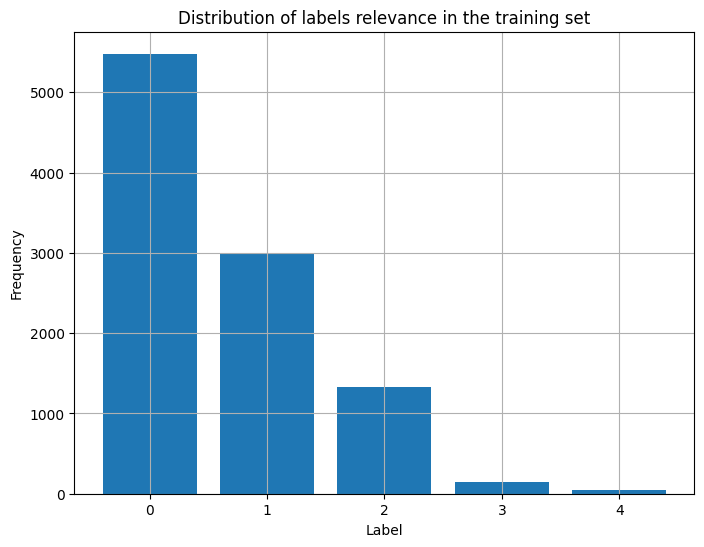

In [13]:
relevance_stats = Counter(y_train)

plt.figure(figsize=(8,6), dpi=100)
plt.grid()
plt.bar(x=relevance_stats.keys(), height=relevance_stats.values());
plt.xlabel("Label"); plt.ylabel("Frequency");
plt.title("Distribution of labels relevance in the training set");

Число уникальных запросов

In [14]:
num_queries = np.unique(queries_train).shape[0]

print("Number of training queries:", num_queries)

Number of training queries: 87


### Подготовка данных

Отнормируем значения релевантности для удобства подсчёта метрик `NDCG`, `PFound`.

In [15]:
from catboost import CatBoostRanker, Pool

In [16]:
!pip freeze | grep catboost

catboost==1.1.1


In [17]:
max_relevance = np.max(y_train)

y_train_norm = y_train / max_relevance
y_test_norm  = y_test  / max_relevance

Создадим пулы с данными.

In [18]:
train = Pool(
    data=X_train,
    label=y_train_norm,
    group_id=queries_train
)
test = Pool(
    data=X_test,
    label=y_test_norm,
    group_id=queries_test
)

In [19]:
import os
from copy import deepcopy

### Замечание

Все объекты в датасете должны быть сгруппированы по group_id.

Например, если датасет состоит из 3 документов $[d_1, d_2, d_3]$ с запросами $[q_1, q_2, q_3]$, то датасет должен выглядеть как:
$$\begin{pmatrix}
    d_1, q_1, f_1\\
    d_2, q_2, f_2\\
    d_3, q_2, f_3\\
\end{pmatrix} \hspace{6px} \texttt{or} \hspace{6px}
\begin{pmatrix}
    d_2, q_2, f_2\\
    d_3, q_2, f_3\\
    d_4, q_1, f_4\\
\end{pmatrix}$$

In [20]:
default_parameters = {
    'iterations': 1000,
    'custom_metric': ['NDCG', 'PFound', 'AverageGain:top=10'],
    'verbose': False,
    'random_seed': 271828,
}

parameters = {}

In [30]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function
    
    if additional_params is not None:
        parameters.update(additional_params)
        
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True)
    
    return model

### RMSE

Первая и простейшая идея: попытаться предсказать релевантность документа, путём минимизации RMSE:
$$
    \frac{1}{N}\sqrt{\sum_q \sum_{d_{qk}}(f(d_{qk}) - l_{qk})^2}
$$

In [22]:
model = fit_model('RMSE', {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

/home/lobuznov/Рабочий стол/Projects/LobuznovDS/Karpov.Courses/HardML/.venv/lib/python3.8/site-packages/catboost/core.py:6240: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Веса групп

Предположим, что нам известно, что некоторые из запросов важнее, чем другие. Тогда почему бы не придать этим запросам больший вес, чем прочим.
* `group_weights` from `CatboostRanker` 

In [31]:
def create_weights(queries: np.ndarray) -> np.ndarray:
    """Calculates the weights for each query

    Parameters
    ----------
    queries : np.ndarray

    Returns
    -------
    weights : np.ndarray
    """
    query_set = np.unique(queries)
    query_weights = np.random.uniform(size=query_set.shape[0])
    weights = np.zeros(shape=queries.shape)
    
    for i, query_id in enumerate(query_set):
        weights[queries == query_id] = query_weights[i]
    
    return weights

In [32]:
train_with_weights = Pool(
    data=X_train,
    label=y_train,
    group_weight=create_weights(queries_train),
    group_id=queries_train
)

test_with_weights = Pool(
    data=X_test,
    label=y_test,
    group_weight=create_weights(queries_test),
    group_id=queries_test
)

fit_model(
    'RMSE', 
    additional_params={'train_dir': 'RMSE_weigths'}, 
    train_pool=train_with_weights,
    test_pool=test_with_weights
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: catboost/libs/metrics/metric.cpp:6381: Max target greater than 1: 4

[Продолжение](https://colab.research.google.com/github/catboost/tutorials/blob/master/ranking/ranking_tutorial.ipynb#scrollTo=YvxXfw9quWG-)